In [0]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [2]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 9, 13)

df = web.DataReader("ACN", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-09,201.119995,192.839996,200.970001,194.830002,2702800.0,194.830002
2019-09-10,193.539993,187.889999,192.979996,189.660004,3631000.0,189.660004
2019-09-11,192.470001,189.240005,190.000000,191.369995,2430300.0,191.369995
2019-09-12,196.229996,191.929993,194.699997,195.520004,2122200.0,195.520004
2019-09-13,196.000000,193.960007,196.000000,194.619995,1592600.0,194.619995


In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

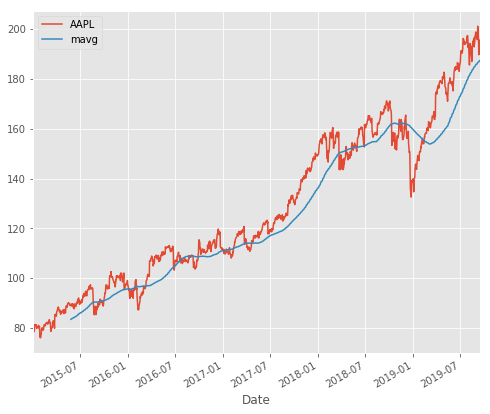

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

In [0]:
dfcomp = web.DataReader(['AAPL', 'ACN', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [6]:
dfcomp.tail()

Symbols,AAPL,ACN,GOOG,IBM,MSFT
Date,,,,,
2019-09-09,214.169998,194.830002,1204.410034,142.600006,137.520004
2019-09-10,216.699997,189.660004,1206.000000,145.050003,136.080002
2019-09-11,223.589996,191.369995,1220.170044,143.600006,136.119995
2019-09-12,223.089996,195.520004,1234.250000,143.619995,137.520004
2019-09-13,218.750000,194.619995,1239.560059,143.669998,137.320007


In [0]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

In [8]:
corr

Symbols,AAPL,ACN,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.476263,0.521463,0.403949,0.577288
ACN,0.476263,1.000000,0.493845,0.524092,0.617786
GOOG,0.521463,0.493845,1.000000,0.411882,0.658512
IBM,0.403949,0.524092,0.411882,1.000000,0.486670
MSFT,0.577288,0.617786,0.658512,0.486670,1.000000


Text(0, 0.5, 'Returns ACN')

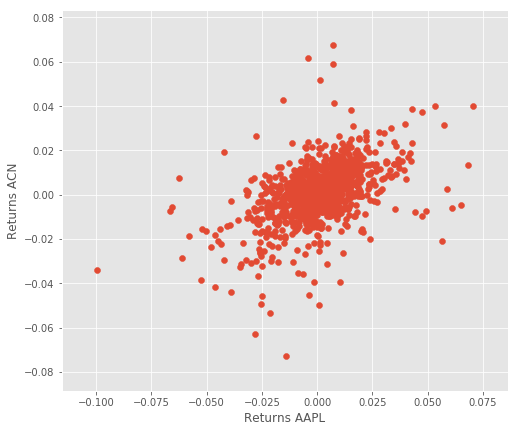

In [12]:
plt.scatter(retscomp.AAPL, retscomp.ACN)
plt.xlabel("Returns AAPL")
plt.ylabel('Returns ACN')

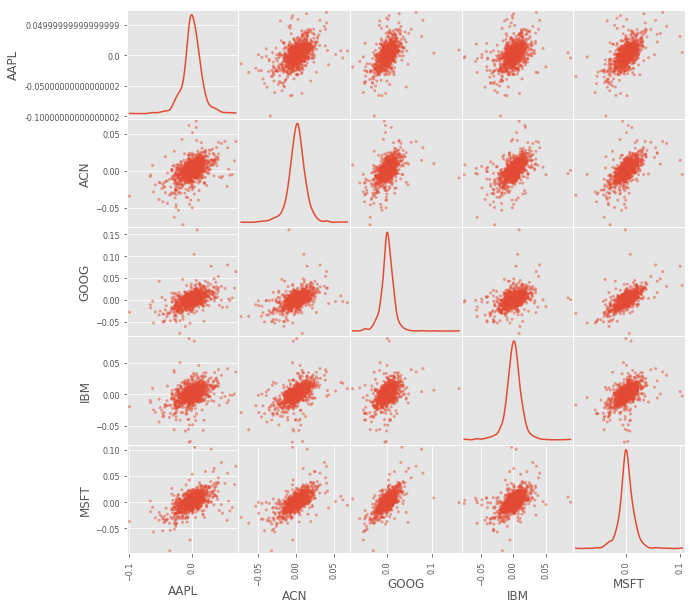

In [17]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

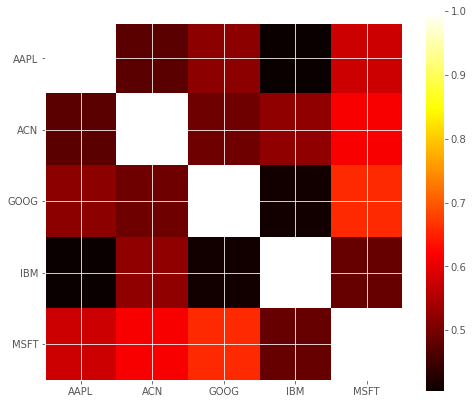

In [16]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

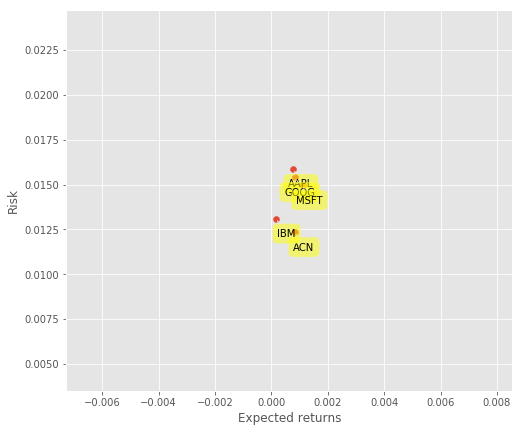

In [18]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [24]:
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-09-09,194.830002,2702800.0,4.249858,-3.055182
2019-09-10,189.660004,3631000.0,2.979012,-1.720381
2019-09-11,191.369995,2430300.0,1.687828,0.721050
2019-09-12,195.520004,2122200.0,2.199265,0.421165
2019-09-13,194.619995,1592600.0,1.048193,-0.704084


In [0]:
import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test = train_test_split(X, test_size=0.3)
y_train, y_test = train_test_split(y, test_size=0.3)

In [34]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [35]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [47]:
#Evaluation
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
# results
print(confidencereg)
print(confidencepoly2)
print(confidencepoly3)
print(confidenceknn)

-0.004852819320614321
-0.022462803957142844
-0.07111604212835498
-0.5106816431297014


In [0]:
# Linear regression
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

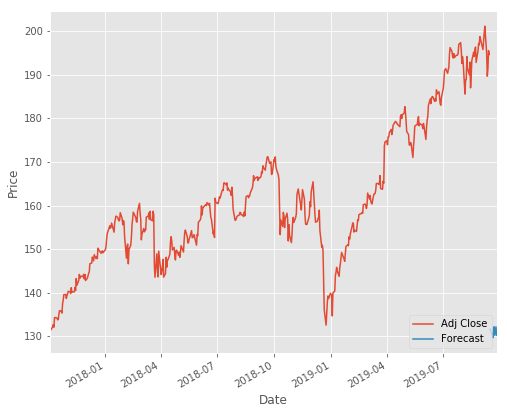

In [46]:
# Linear regression Plotting the Prediction
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [0]:
# Quadratic Regression
forecast_set = clfpoly2.predict(X_lately)
dfreg['Forecast'] = np.nan

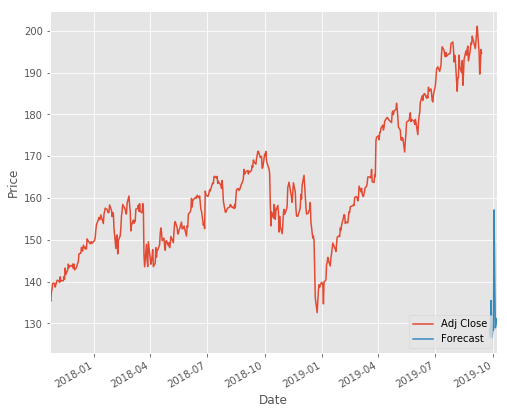

In [49]:
# Quadratic Regression Plotting the Prediction
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [0]:
# KNN Regression
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

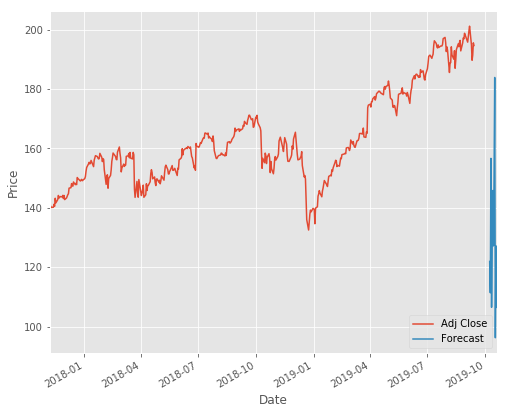

In [51]:
# KNN Regression Plotting the Prediction
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()